In [1]:
"""
Lets fit a OU process over a few different time frames and backtest XETXBT
"""

import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
from statsmodels.multivariate.pca import PCA
"""brownian_motion.py"""

from typing import Optional

import numpy as np


def get_corr_dW_matrix(
    T: int,
    n_procs: int,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    2D array of n_procs discrete Brownian Motion increments dW.
    Each column of the array is one process.
    So that the resulting shape of the array is (T, n_procs).
        - T is the number of samples of each process.
        - The correlation constant rho is used to generate a new process,
            which has rho correlation to a random process already generated,
            hence rho is only an approximation to the pairwise correlation.
        - Optional random_state to reproduce results.
    """
    rng = np.random.default_rng(random_state)
    dWs: list[np.ndarray] = []
    for i in range(n_procs):
        random_state_i = _get_random_state_i(random_state, i)
        if i == 0 or rho is None:
            dW_i = get_dW(T, random_state=random_state_i)
        else:
            dW_corr_ref = _get_corr_ref_dW(dWs, i, rng)
            dW_i = _get_correlated_dW(dW_corr_ref, rho, random_state_i)
        dWs.append(dW_i)
    return np.asarray(dWs).T


def get_dW(T: int, random_state: Optional[int] = None) -> np.ndarray:
    """
    Sample T times from a normal distribution,
    to simulate discrete increments (dW) of a Brownian Motion.
    Optional random_state to reproduce results.
    """
    np.random.seed(random_state)
    return np.random.normal(0.0, 1.0, T)


def get_W(T: int, random_state: Optional[int] = None) -> np.ndarray:
    """
    Simulate a Brownian motion discretely samplet at unit time increments.
    Returns the cumulative sum
    """
    dW = get_dW(T, random_state)
    # cumulative sum and then make the first index 0.
    dW_cs = dW.cumsum()
    return np.insert(dW_cs, 0, 0)[:-1]


def _get_correlated_dW(
    dW: np.ndarray, rho: float, random_state: Optional[int] = None
) -> np.ndarray:
    """
    Sample correlated discrete Brownian increments to given increments dW.
    """
    dW2 = get_dW(
        len(dW), random_state=random_state
    )  # generate Brownian icrements.
    if np.array_equal(dW2, dW):
        # dW cannot be equal to dW2.
        raise ValueError(
            "Brownian Increment error, try choosing different random state."
        )
    return rho * dW + np.sqrt(1 - rho ** 2) * dW2


def _get_random_state_i(random_state: Optional[int], i: int) -> Optional[int]:
    """Add i to random_state is is int, else return None."""
    return random_state if random_state is None else random_state + i


def _get_corr_ref_dW(
    dWs: list, i: int, rng: np.random.Generator
) -> np.ndarray:
    """
    Choose randomly a process (dW) the from the
    already generated processes (dWs).
    """
    random_proc_idx = rng.choice(i)
    return dWs[random_proc_idx]

"""OU_proc.py"""

from dataclasses import dataclass
from typing import Optional, Union

import numpy as np

from sklearn.linear_model import LinearRegression



# ----------------------------------------------------------------
# OU process


@dataclass
class OUParams:
    alpha: float  # mean reversion parameter
    gamma: float  # asymptotic mean
    beta: float  # Brownian motion scale (standard deviation)


def get_OU_process(
    T: int,
    OU_params: OUParams,
    X_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - Ou_params is an instance of OUParams dataclass.
    - X_0 the initial value for the process, if None, then X_0 is taken
        to be gamma (the asymptotic mean).
    Returns a 1D array.
    """
    t = np.arange(T, dtype=np.float64)  # float to avoid np.exp overflow
    exp_alpha_t = np.exp(-OU_params.alpha * t)
    dW = get_dW(T, random_state)
    integral_W = _get_integal_W(t, dW, OU_params)
    _X_0 = _select_X_0(X_0, OU_params)
    return (
        _X_0 * exp_alpha_t
        + OU_params.gamma * (1 - exp_alpha_t)
        + OU_params.beta * exp_alpha_t * integral_W
    )


def _select_X_0(X_0_in: Optional[float], OU_params: OUParams) -> float:
    """Returns X_0 input if not none, else gamma (the long term mean)."""
    if X_0_in is not None:
        return X_0_in
    return OU_params.gamma


def _get_integal_W(
    t: np.ndarray, dW: np.ndarray, OU_params: OUParams
) -> np.ndarray:
    """Integral with respect to Brownian Motion (W), ∫...dW."""
    exp_alpha_s = np.exp(OU_params.alpha * t)
    integral_W = np.cumsum(exp_alpha_s * dW)
    return np.insert(integral_W, 0, 0)[:-1]


# ----------------------------------------------------------------
# OU parameters from data with OLS.


def estimate_OU_params(X_t: np.ndarray) -> OUParams:
    """
    Estimate OU params from OLS regression.
    - X_t is a 1D array.
    Returns instance of OUParams.
    """
    y = np.diff(X_t)
    X = X_t[:-1].reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    # regression coeficient and constant
    alpha = -reg.coef_[0]
    gamma = reg.intercept_ / alpha
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    beta = np.std(y - y_hat)
    return OUParams(alpha, gamma, beta)



In [2]:
#last 2 years of history 
start_date = datetime.today()- \
                        relativedelta(days = 2*252) #datetime.strptime(df.index[-10],'%d/%m/%Y')

#set end date (t)
end_date = datetime.today()#.strftime('%d/%m/%Y')
ticker1 = 'MSTR US Equity'
ticker2 = 'BITO US Equity'
ticker = [ticker1,ticker2]
#lets do outright futures, swap spreads and future spreads
fut = blp.bdh(tickers=ticker
             , flds=['Px_last'],
             start_date= start_date, end_date=end_date,Per='D')
fut.index.names = ['date']
#fut.index = fut.index.strftime('%d/%m/%Y')
fut.columns = fut.columns.droplevel(1)
fut['spread']= fut[ticker1]/fut[ticker2]
fut = fut[['spread']].copy()
fut.rename(columns={ fut.columns[0]: "px" }, inplace = True)

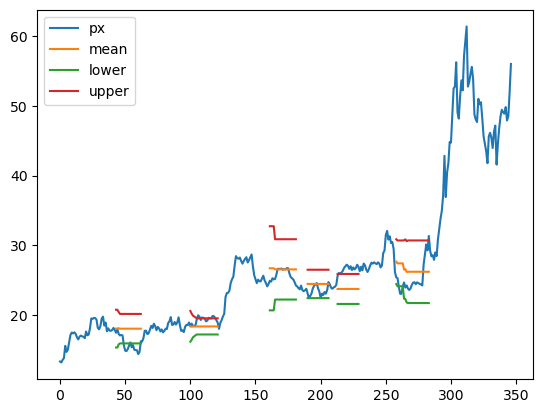

In [4]:
#last 2 years of history 
start_date = datetime.today()- \
                        relativedelta(days = 2*252) #datetime.strptime(df.index[-10],'%d/%m/%Y')

#set end date (t)
end_date = datetime.today()#.strftime('%d/%m/%Y')
ticker1 = 'MSTR US Equity'
ticker2 = 'BITO US Equity'
ticker = [ticker1,ticker2]
#lets do outright futures, swap spreads and future spreads
fut = blp.bdh(tickers=ticker
             , flds=['Px_last'],
             start_date= start_date, end_date=end_date,Per='D')
fut.index.names = ['date']
#fut.index = fut.index.strftime('%d/%m/%Y')
fut.columns = fut.columns.droplevel(1)
fut['spread']= fut[ticker1]/fut[ticker2]
fut = fut[['spread']].copy()
fut.rename(columns={ fut.columns[0]: "px" }, inplace = True)
# for different lookback periods, shift across and test ADF
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS, add_constant
from statsmodels.regression.rolling import RollingOLS

adf_stationary_pvalues = {}
ou_alpha = {} #speed of MR
ou_gamma ={} # mean
ou_beta ={} #standard dev
ou_half_life= {}
ou_std = {}
ou_upper_bound =  {}
ou_lower_bound =  {}
lookback = 40
#lookback = 20*3
std_multiplier =2
for i in range(0,len(fut)-lookback+1):
    #print(i)
    ts = fut[i:lookback+i]
    ts_std= ts.std().mean()#ts.ewm(com = lookback).std()
    result = adfuller(ts)
    if result[1]<0.05:
        adf_stationary_pvalues[lookback+i]= result[1]
        OU_params = estimate_OU_params(ts['px'].values)
        if OU_params.alpha>0: #otherwise mean reversion speed is negative and the model explodes!
            ou_alpha[lookback+i]=OU_params.alpha
            ou_gamma[lookback+i]=OU_params.gamma
            ou_beta[lookback+i]=OU_params.beta
            ou_half_life[lookback+i]=np.log(2)/OU_params.alpha
            ou_std[lookback+i] = ts_std
            ou_upper_bound[lookback+i] = OU_params.gamma+ std_multiplier*ts_std
            ou_lower_bound[lookback+i] = OU_params.gamma- std_multiplier*ts_std
    
#position taking based on px above or below gamma (mean) and if px above or below 2std (mean + 2std)
pos_df = fut.reset_index()

pos_df['mean'] = pos_df.index.map(ou_gamma)
pos_df['lower'] = pos_df.index.map(ou_lower_bound)
pos_df['upper'] = pos_df.index.map(ou_upper_bound)    
pos_df['half_life'] = pos_df.index.map(ou_half_life)    
#pos_df['indicator_life'] =  np.floor(pd.to_numeric(pos_df['half_life'], errors='coerce')).astype('Int64')
#pos_df['indicator_life'] = pos_df['indicator_life'].fillna(0)*2
trade_limit = int(pos_df['half_life'].mean()*3)

#ffill for na situations so we have sufficient time for the indicator to look for an entry
pos_df['mean'] = pos_df['mean'].fillna(method = 'ffill', limit = trade_limit)
pos_df['upper'] = pos_df['upper'].fillna(method = 'ffill', limit = trade_limit)
pos_df['lower'] = pos_df['lower'].fillna(method = 'ffill', limit = trade_limit)
pos_df[['px','mean','lower','upper']].plot()

def condition(x):
    if x['px']>x['upper']:
        return -1
    elif x['px']<x['lower']:
        return 1
    #elif x['px']==x['mean']:
    #    return 0 
pos_df['entry_position'] =  pos_df.apply( lambda x: condition(x), axis =1)
pos_df['entry_position_ffill'] = pos_df['entry_position'].fillna(method = 'ffill', limit = trade_limit)


#add date and daytime

#string to date time
pos_df['date'] = pd.to_datetime(pos_df['date'])
pos_df['day'] = pos_df['date'].dt.day_name()#.day_name()

<AxesSubplot:>

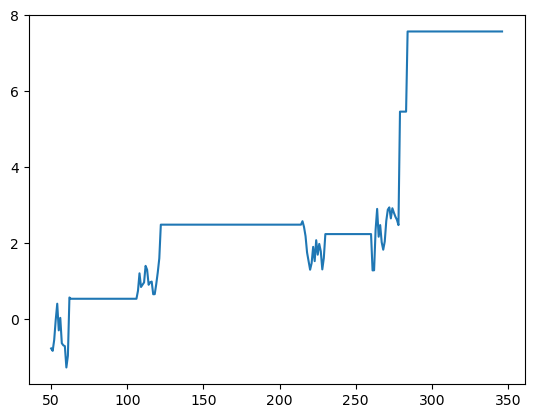

In [5]:

pos_df2 = pos_df.copy()
#2
def remove_positions_outsidewindow(x):
    if (pd.notnull(x['entry_position_ffill']))& (pd.isnull(x['mean'])):
    #if (x['entry_position']!=0) & (x['mean']==0):
        return 0
    else:
        return x['entry_position_ffill']
        
pos_df2['pos1']= pos_df2.apply(lambda x: remove_positions_outsidewindow(x), axis =1)
#3
def pos_close(x):
    if (x['px']>x['mean'])&(x['pos1']==1):
        return 0
    elif (x['px']<x['mean'])&(x['pos1']==-1):
        return 0
pos_df2['pos2']= pos_df2.apply(lambda x: pos_close(x), axis =1)
#4
def add_closeout(x):
    if (x['pos2']==0):
        return 0
    elif (pd.notnull(x['entry_position'])):
        return x['entry_position']
    elif (x['pos1']==0):
        return 0   

pos_df2['pos3']= pos_df2.apply(lambda x: add_closeout(x), axis =1)
#5
pos_df2['pos3'] = pos_df2['pos3'].fillna(method = 'ffill')
#6
pos_df2['px_diff']= pos_df2['px'].diff()
pos_df2['px_diff_pct']= pos_df2['px'].diff()/pos_df2['px']
pos_df2['return'] = pos_df2['pos3'].shift()*pos_df2['px_diff_pct']
pos_df2['raw_return'] = pos_df2['pos3'].shift()*pos_df2['px_diff']
def deduct_brokerage(x):
    if (x['pos3']==0):
        return x['px_diff_pct']-(0.10/100) #10bps entry and exit
    else:
        return x['px_diff_pct']   

pos_df2['px_diff_pct_with_brokerage'] = pos_df2.apply(lambda x: deduct_brokerage(x), axis =1)
pos_df2['return_withbro'] = pos_df2['pos3'].shift()*pos_df2['px_diff_pct_with_brokerage']
pos_df2['raw_return'].cumsum().plot()
#pos_df2['return_withbro'].cumsum().plot()

In [5]:
pos_df[['date','px','mean','lower','upper','half_life']]

,date,px,mean,lower,upper,half_life
0,2022-02-28,0.067728,NaN,NaN,NaN,NaN
1,2022-03-01,0.067346,NaN,NaN,NaN,NaN
2,2022-03-02,0.067515,NaN,NaN,NaN,NaN
3,2022-03-03,0.066639,NaN,NaN,NaN,NaN
4,2022-03-04,0.066212,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
752,2024-03-21,0.053217,0.054848,0.050914,0.058782,NaN
753,2024-03-22,0.052242,0.054848,0.050914,0.058782,NaN
754,2024-03-23,0.052103,0.054848,0.050914,0.058782,NaN
755,2024-03-24,0.051598,0.054848,0.050914,0.058782,NaN


In [44]:
pos_df2

,date,px,mean,lower,upper,half_life,entry_position,entry_position_ffill,day,pos1,pos2,pos3,px_diff,px_diff_pct,return,raw_return,px_diff_pct_with_brokerage,return_withbro
0,2022-02-01,0.072107,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-02-02,0.071904,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,NaN,NaN,NaN,-0.000203,-0.002828,NaN,NaN,-0.002828,NaN
2,2022-02-03,0.071988,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,NaN,NaN,NaN,0.000084,0.001169,NaN,NaN,0.001169,NaN
3,2022-02-04,0.072736,NaN,NaN,NaN,NaN,NaN,NaN,Friday,NaN,NaN,NaN,0.000748,0.010282,NaN,NaN,0.010282,NaN
4,2022-02-05,0.072561,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,NaN,NaN,NaN,-0.000175,-0.002409,NaN,NaN,-0.002409,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2024-02-23,0.057717,NaN,NaN,NaN,NaN,NaN,NaN,Friday,NaN,NaN,0.0,-0.000070,-0.001220,-0.0,-0.0,-0.002220,-0.0
753,2024-02-24,0.057902,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,NaN,NaN,0.0,0.000185,0.003200,0.0,0.0,0.002200,0.0
754,2024-02-25,0.060064,0.056281,0.050650,0.061912,11.292046,NaN,NaN,Sunday,NaN,NaN,0.0,0.002162,0.035995,0.0,0.0,0.034995,0.0
755,2024-02-26,0.058289,0.057839,0.052062,0.063616,13.629401,NaN,NaN,Monday,NaN,NaN,0.0,-0.001775,-0.030457,-0.0,-0.0,-0.031457,-0.0


In [27]:
pos_df2[['return']]#.dropna()
sharpe = np.sqrt(252)*np.mean(pos_df2[['return']].dropna())/np.std(pos_df2[['return']].dropna())
sharpe

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


return    0.892745
dtype: float64

<AxesSubplot:>

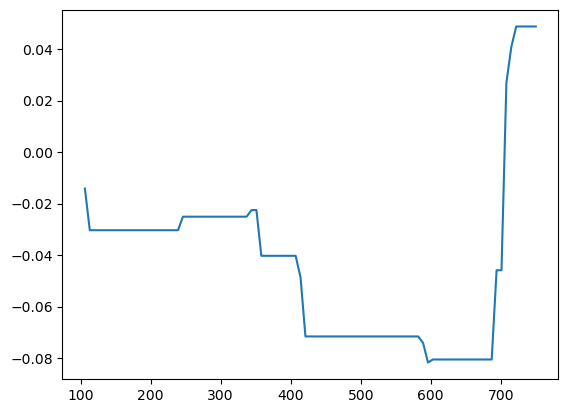

In [46]:
pos_df2[pos_df2['day']=='Wednesday']['return'].cumsum().plot(label = day)

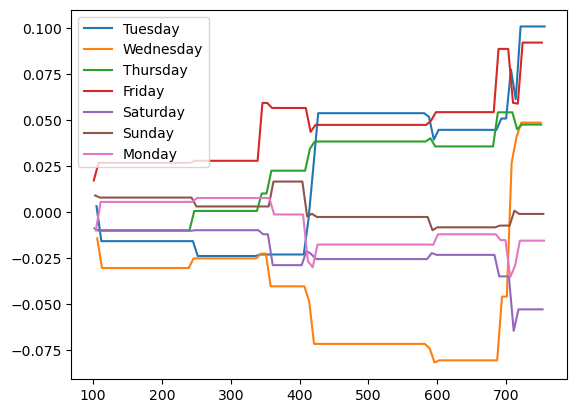

In [42]:
#lets look at seasonality by day of week
seas_df = pos_df2.copy()#['day'].unique()
for day in pos_df2['day'].unique():
    pos_df2[pos_df2['day']==day]['return'].cumsum().plot(label = day)

plt.legend()
plt.show()

<AxesSubplot:>

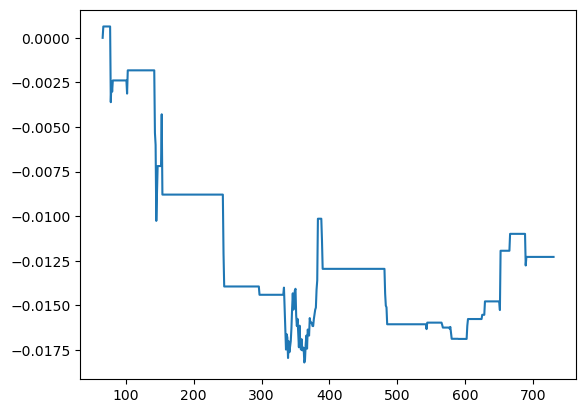

In [335]:
pos_df2['raw_return'].cumsum().plot()

In [203]:
pos_df2['return']= pos_df2['px'].diff()/pos_df2['px']

<AxesSubplot:>

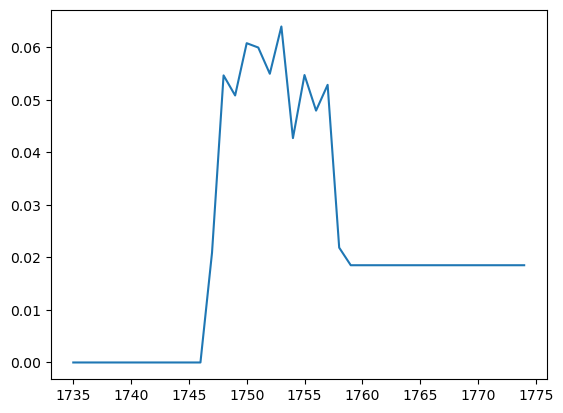

In [278]:
pos_df2['return'].tail(40).cumsum().plot()

In [214]:
pos_df2.to_csv('20day_MR.csv')

<AxesSubplot:>

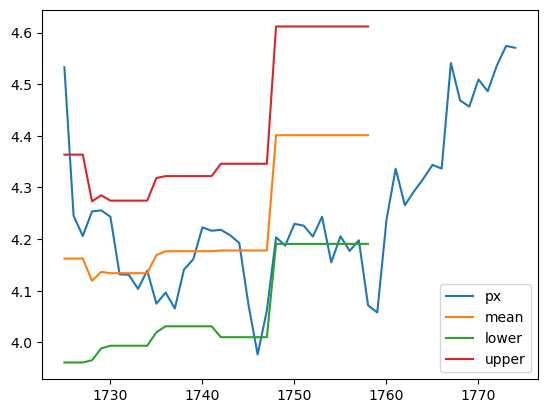

In [276]:
pos_df2[['px','mean','lower','upper']].tail(50).plot()

<AxesSubplot:>

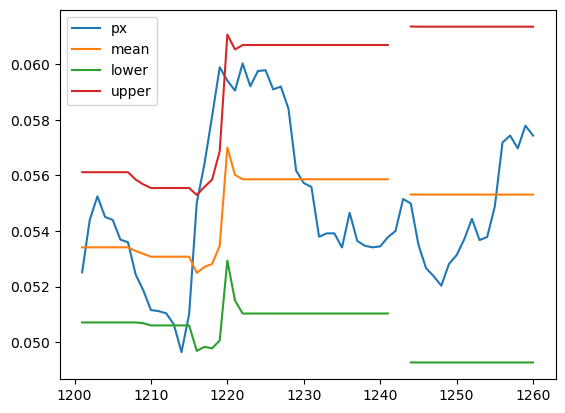

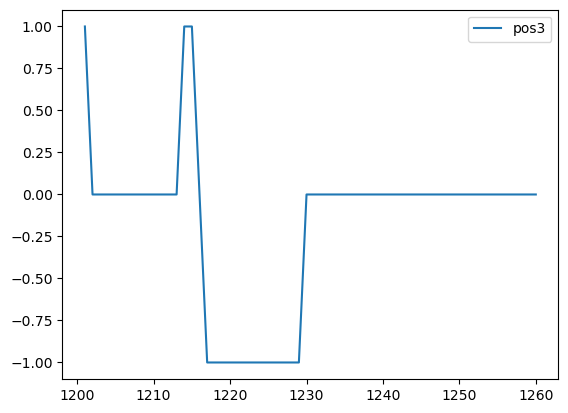

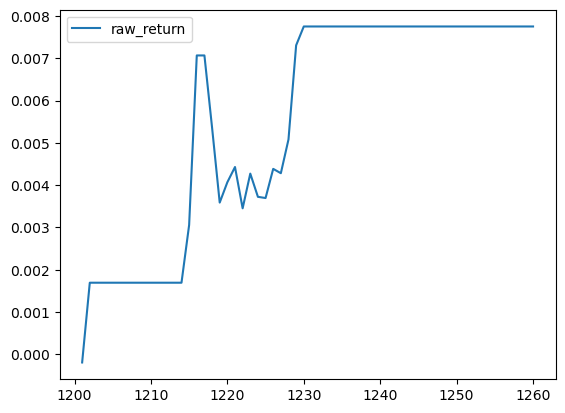

In [367]:
pos_df2[['px','mean','lower','upper']].tail(60).plot()
pos_df2[['pos3']].tail(60).plot()
pos_df2[['raw_return']].cumsum().tail(60).plot()

In [265]:
pos_df2.to_csv('btcmr.csv')

In [241]:
pos_df2[['px','mean','lower','upper','pos3','return']].tail(20)

,px,mean,lower,upper,pos3,return
1555,0.053412,0.054494,0.05164,0.057348,0.0,-0.000000
1556,0.054657,0.054494,0.05164,0.057348,0.0,0.000000
1557,0.053643,0.054494,0.05164,0.057348,0.0,-0.000000
1558,0.053466,0.054494,0.05164,0.057348,0.0,-0.000000
1559,0.053412,0.054494,0.05164,0.057348,0.0,-0.000000
1560,0.054003,0.054494,0.05164,0.057348,0.0,0.000000
1561,0.055159,0.054494,0.05164,0.057348,0.0,0.000000
1562,0.054995,0.054494,0.05164,0.057348,0.0,-0.000000
1563,0.053518,0.054494,0.05164,0.057348,0.0,-0.000000
1564,0.052681,0.054494,0.05164,0.057348,0.0,-0.000000


In [135]:
def condition(x):
    if x['px']>x['upper']:
        return -1
    elif x['px']<x['lower']:
        return 1
    #elif x['px']==x['mean']:
    #    return 0 
pos_df['entry_position'] =  pos_df.apply( lambda x: condition(x), axis =1)

In [250]:

#string to date time
pos_df['date'] = pd.to_datetime(pos_df['date'])
pos_df['day'] = pos_df['date'].dt.day_name()#.day_name()

In [251]:
pos_df

,date,px,mean,lower,upper,half_life,entry_position,entry_position_ffill,day
0,2018-02-12,0.098707,0.076431,0.060273,0.092589,4.615372,-1.0,-1.0,Monday
1,2018-02-13,0.097920,0.076431,0.060273,0.092589,NaN,-1.0,-1.0,Tuesday
2,2018-02-14,0.097617,0.076431,0.060273,0.092589,NaN,-1.0,-1.0,Wednesday
3,2018-02-15,0.093122,0.076431,0.060273,0.092589,NaN,-1.0,-1.0,Thursday
4,2018-02-16,0.092902,0.076431,0.060273,0.092589,NaN,-1.0,-1.0,Friday
...,...,...,...,...,...,...,...,...,...
1570,2024-02-19,0.057181,0.054494,0.051640,0.057348,NaN,NaN,-1.0,Monday
1571,2024-02-20,0.057434,0.054494,0.051640,0.057348,NaN,-1.0,-1.0,Tuesday
1572,2024-02-21,0.056973,0.054494,0.051640,0.057348,NaN,NaN,-1.0,Wednesday
1573,2024-02-22,0.057792,0.054494,0.051640,0.057348,NaN,-1.0,-1.0,Thursday


<AxesSubplot:>

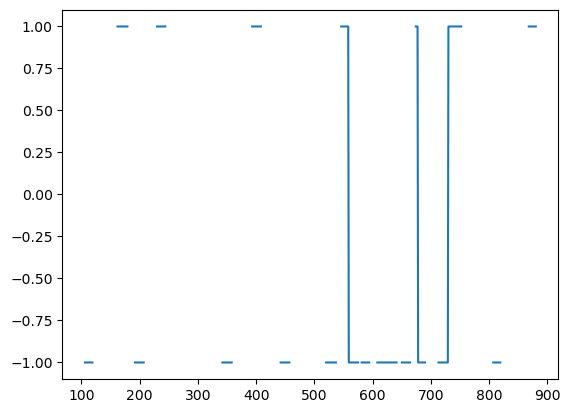

In [139]:
pos_df['entry_position'] = pos_df['entry_position'].fillna(method = 'ffill', limit = trade_limit)
pos_df['entry_position'].plot()

<AxesSubplot:>

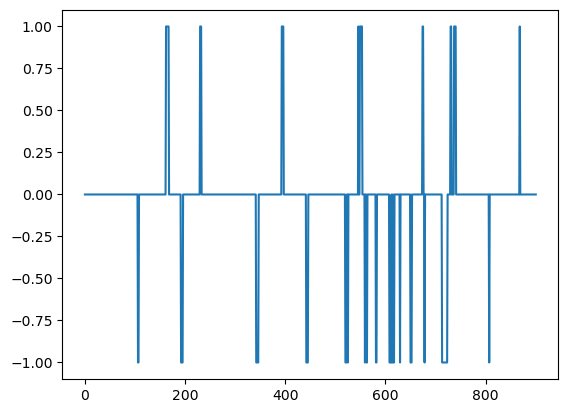

In [119]:
pos_df['entry_position'].plot()

In [95]:
pos_df['half_life'].mean()

4.138294641907346

In [94]:
pos_df#[['indicator_life']].plot()

,date,XETXBT Curncy,mean,lower,upper,half_life,indicator_life
0,2020-09-09,0.034451,NaN,NaN,NaN,NaN,0
1,2020-09-10,0.035495,NaN,NaN,NaN,NaN,0
2,2020-09-11,0.035690,NaN,NaN,NaN,NaN,0
3,2020-09-14,0.035205,NaN,NaN,NaN,NaN,0
4,2020-09-15,0.033652,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...
896,2024-02-15,0.054443,NaN,NaN,NaN,NaN,0
897,2024-02-16,0.053686,NaN,NaN,NaN,NaN,0
898,2024-02-19,0.057181,NaN,NaN,NaN,NaN,0
899,2024-02-20,0.057434,NaN,NaN,NaN,NaN,0


In [90]:
pos_df['indicator_life']

0      0
1      0
2      0
3      0
4      0
      ..
896    0
897    0
898    0
899    0
900    0
Name: indicator_life, Length: 901, dtype: Int64

In [96]:
mask = pos_df['indicator_life'].notnull()
pos_df['mean3'] = pos_df['mean'].where(mask, pos_df['mean'].fillna(method = 'ffill', limit = 1))

pos_df['mean2'] = pos_df['mean'].fillna(method = 'ffill', limit = 8)

<AxesSubplot:>

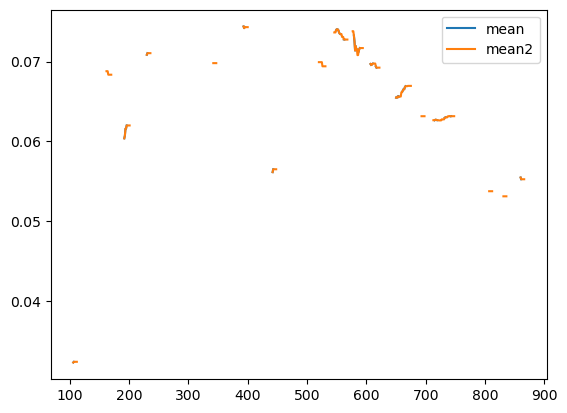

In [86]:
pos_df[['mean','mean2']].plot()

In [89]:
pos_df.to_csv('mean_ffill.csv')

In [58]:
#round(pos_df['half_life'],0).dropna()

pos_df['half_life'].apply(pd.to_numeric, args=('coerce',)).dropna()

106    3.483966
107    2.291077
162    4.670762
165    3.737518
192    5.055744
         ...   
743    1.621665
807    2.000080
831    2.053217
860    6.309541
861    6.264984
Name: half_life, Length: 78, dtype: float64

In [63]:
 np.floor(pd.to_numeric(pos_df['half_life'], errors='coerce')).astype('Int64')

106    3
107    2
162    4
165    3
192    5
      ..
743    1
807    2
831    2
860    6
861    6
Name: half_life, Length: 78, dtype: Int64

In [61]:
pos_df['half_life'].astype('Int64')

TypeError: cannot safely cast non-equivalent float64 to int64

In [36]:
pos_df = fut.reset_index()
pos_df['mean'] = pos_df.index.map(ou_gamma)
pos_df['lower'] = pos_df.index.map(ou_lower_bound)
pos_df['upper'] = pos_df.index.map(ou_upper_bound)

<AxesSubplot:>

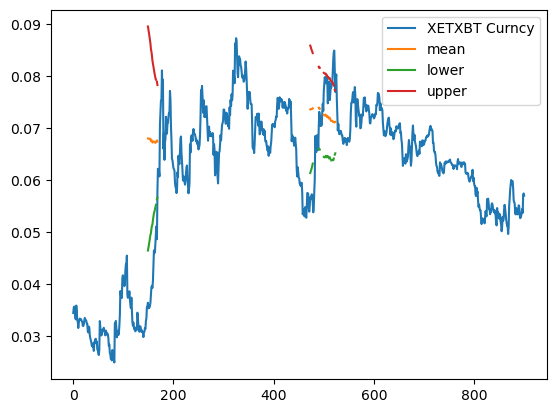

In [39]:
pos_df[['XETXBT Curncy','mean','lower','upper']].plot()

In [26]:
#position taking based on px above or below gamma (mean) and if px above or below 2std (mean + 2std)
pos= {}

for i in adf_stationary_pvalues:
    print(i)
    ts = fut[i:lookback+i]
    #ts_std= ts.ewm(com = 20).std()
    #print(ts_std.iloc[-1].mean())
    mean = ou_gamma[i]
    upper = ou_upper_bound[i]
    lower = ou_lower_bound[i]
    current_px = ts.iloc[-1].mean()
    print(current_px)
    print(lower,mean,upper)
    
    if current_px > (upper):
        pos[i]= -1
    elif current_px < (lower):
        pos[i]= 1
    else:
        pos[i] = 0
        


149
0.068512
0.04646165781400205 0.06799103034512799 0.08952040287625393
150
0.06859
0.04697865632385215 0.06797589994856224 0.08897314357327232
151
0.068438
0.04754025004701 0.06793101721167127 0.08832178437633255
152
0.068405
0.048138582912777436 0.06790200858033515 0.08766543424789287
153
0.069045
0.048861510874910564 0.06796131451575944 0.08706111815660833
154
0.06849
0.04947435627908292 0.06788205755475071 0.0862897588304185
155
0.064848
0.04978818967568935 0.06748254255718397 0.0851768954386786
156
0.066887
0.050635950187700826 0.06766019125987657 0.08468443233205232
157
0.065848
0.051192676061256444 0.06758011199410083 0.08396754792694522
158
0.060909
0.051469356327237474 0.06721705641196742 0.08296475649669735
159
0.062831
0.05229502592650494 0.06733090716044896 0.08236678839439297
160
0.062723
0.052930294216678386 0.06728796447983915 0.0816456347429999
161
0.065435
0.05363384285993944 0.06742867854714787 0.08122351423435631
162
0.062082
0.05392116126767744 0.06728158458157746 

In [27]:
pos

{149: 0,
 150: 0,
 151: 0,
 152: 0,
 153: 0,
 154: 0,
 155: 0,
 156: 0,
 157: 0,
 158: 0,
 159: 0,
 160: 0,
 161: 0,
 162: 0,
 163: 0,
 164: 0,
 165: 0,
 167: 0,
 168: 0,
 171: 0,
 176: 0,
 178: 0,
 473: 0,
 474: 0,
 475: 0,
 476: 0,
 477: 0,
 478: 0,
 485: 0,
 490: 0,
 491: 0,
 492: 0,
 500: 0,
 501: 0,
 502: 0,
 504: 0,
 505: 0,
 506: 0,
 508: 0,
 509: 0,
 510: 0,
 512: 0,
 513: 0,
 515: 0,
 516: 0,
 517: 0,
 518: 0,
 519: 0,
 520: 0,
 522: 0,
 523: 0}

In [ ]:
s = 177
fwd_look = 100
#fut[s:(s+lookback+1)].plot()
ts_std_fixed = fut[s:(s+lookback+1+30)].std().mean()
ts_std= fut[s:(s+lookback+1+fwd_look)].ewm(com = 20).std()
plt.plot(fut[s:(s+lookback+1)].values, label = 'px')
plt.plot(fut[s:(s+lookback+1+fwd_look)].values,color = 'm', alpha=0.5,label = 'fwd_px')
#plt.plot(np.concatenate([price_series['ratio'].values, OU_simulation_df.mean().values]), label = 'Simulated Path')
plt.axhline(y=ou_gamma[s], color = 'b',linestyle = '--', label = 'Long-term Mean')

plt.plot(ou_gamma[s]-2*ts_std.bfill().values, color = 'r',linestyle = '--', label = 'lower rolling 2std')
plt.plot(ou_gamma[s]+2*ts_std.bfill().values,color = 'r',linestyle = '--', label = 'upper rolling 2std')
plt.axhline(y = ou_gamma[s]-2*ts_std_fixed, color = 'g',linestyle = '--', label = 'lower fixed 2std')
plt.axhline(y = ou_gamma[s]+2*ts_std_fixed,color = 'g',linestyle = '--', label = 'upper fixed 2std')
#plt.plot(rolling_ewma_price.values, label = 'rolling ema px')


plt.title('MR Strategy Visual')
plt.xlabel('time steps')
plt.ylabel('value')
plt.legend()
plt.show()

In [51]:
ts_std= fut[s:(s+lookback+1)].std().mean()
ts_std

0.006100734485040949

In [55]:
ou_gamma[s]-2*ts_std

0.06139415867420303